## Project: Articles published prediction using machine learning
- **Source**: Long (1990), The origins of sex differences in science, Social Forces, 68, 1297-1315 
- **URL**: https://support.sas.com/kb/26/161.html
- **Date**: 05/12/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Load libraries and custom modules
# Basics ---------------------------------------------------------------
import os
import joblib
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
from patsy import dmatrices
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data
# 1.1 Retrieve data from source and get basic info
url = (
    'https://raw.githubusercontent.com/flh3/'+
    'pubdata/main/miscdata/articles.csv'
)
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fem     915 non-null    int64  
 1   ment    915 non-null    float64
 2   phd     915 non-null    float64
 3   mar     915 non-null    int64  
 4   kid5    915 non-null    int64  
 5   art     915 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 43.0 KB


In [3]:
# 1.2 Show a sample
df_raw.sample(10, random_state=2024)

,fem,ment,phd,mar,kid5,art
407,0,12.000000,2.87,0,0,3
93,0,6.000000,1.80,1,2,3
89,0,0.000000,4.29,1,2,3
863,1,9.999999,3.69,1,1,2
876,1,9.000000,2.26,1,1,1
86,0,4.999998,2.58,1,2,0
297,0,17.000000,4.29,1,0,2
587,1,2.000000,1.28,1,0,1
496,1,2.000000,2.12,1,0,2
180,0,47.000008,1.86,1,1,9


**Data dictionary**

|Variable Name|Role|Type|Description|Units|Missing Values|
|-------------|----|----|-----------|-----|--------------|
|art|target|integer|Number of articles published by the scientist||no|
|fem|feature|int|Gender|1 or 0|no|
|ment|feature|float|Number of articles published by scientist's mentor||no|
|phd|feature|float|Prestige of graduate program||no|
|mar|feature|integer|Marital status|1 or 0|no|
|kid5|feature|integer|Number of children||no|

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Step 2. Perform data preprocessing as expected by your data dictionary
# 2.1 Make the chain for transformations
df = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates()
    .rename(columns={'art':'target'})
    .iloc[:, [5] + [c for c in range(6) if c!= 5]]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 885 entries, 0 to 914
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  885 non-null    int64  
 1   fem     885 non-null    int64  
 2   ment    885 non-null    float64
 3   phd     885 non-null    float64
 4   mar     885 non-null    int64  
 5   kid5    885 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 48.4 KB


In [5]:
# 2.2 Show final dataset and save it
display(df)
df.to_csv('../data/articles_published.csv')

,target,fem,ment,phd,mar,kid5
0,3,0,7.999999,1.380,1,2
1,0,0,7.000000,4.290,0,0
2,4,0,47.000008,3.850,0,0
3,1,0,19.000002,3.590,1,1
4,1,0,0.000000,1.810,1,0
...,...,...,...,...,...,...
910,1,1,0.000000,2.120,1,0
911,2,1,4.999998,3.750,0,0
912,0,1,0.000000,0.755,0,0
913,1,1,7.000000,2.250,0,0


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [7]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 708 entries, 589 to 670
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  708 non-null    int64  
 1   fem     708 non-null    int64  
 2   ment    708 non-null    float64
 3   phd     708 non-null    float64
 4   mar     708 non-null    int64  
 5   kid5    708 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 38.7 KB


In [8]:
# 3.2 Show descriptive statistics
display(df_train.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
target,708.0,1.709040,1.967940,0.000,0.00,1.00,2.00,19.000000
fem,708.0,0.475989,0.499776,0.000,0.00,0.00,1.00,1.000000
ment,708.0,8.877118,9.635676,0.000,3.00,6.00,12.00,76.999985
phd,708.0,3.122182,0.983531,0.755,2.26,3.19,3.92,4.620000
mar,708.0,0.662429,0.473216,0.000,0.00,1.00,1.00,1.000000
kid5,708.0,0.514124,0.769705,0.000,0.00,0.00,1.00,3.000000


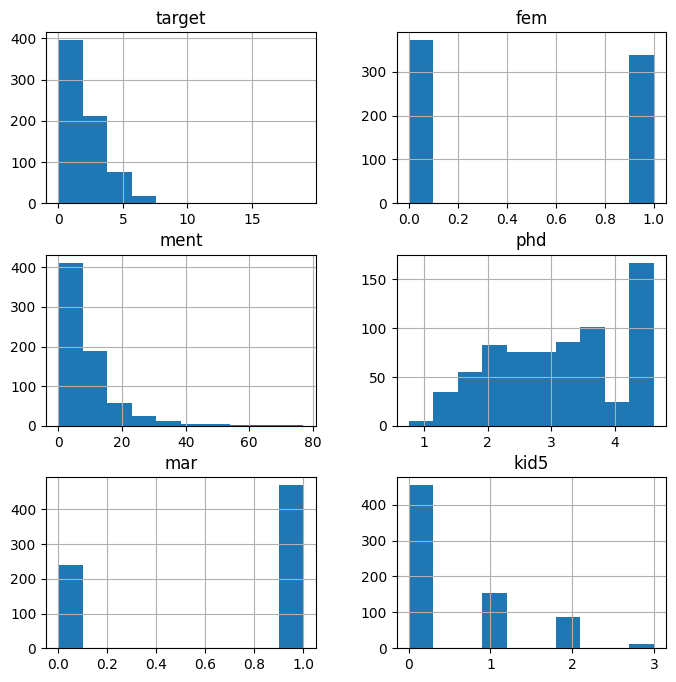

In [9]:
# 3.3 Display univariate analysis - Numeric 
df_train.hist(figsize=(8,8))
plt.show()

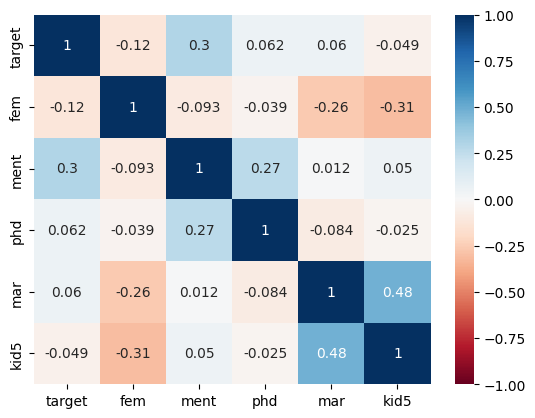

In [10]:
# 3.4 Perform correlation analysis
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions